In [2]:
import numpy as np
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import shapely.geometry as sg
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5, ipysliderule, io
import warnings
from IPython import display
import json
import utils.toolshelf as t
import LagrangianDEMdifferencing.utils.lagrange as lagrange
from random import sample

import fiona


warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
# # Select predetermined track (2 digit cycle number)
site = "filchnerF1"
site = "ross1"
cycStart = 5
cycEnd = 16

# resolution (recommended 20.0)
# "len" and "res" (will be equal)
res = 20.0
cnf = 2

#output options
# Save flag (0: dont save, 1: save as geojson (slow but everything works)
sFlag = 0

shpPath = f"../shapes/mel_res{int(res)}.geojson"
#shpPath = f"../shapes/{site}_2019-09-03_04.geojson"
#shpPath = f"../shapes/{site}.geojson"

datRoot = f"../data/"
figRoot = f"../figs/{site}/"

In [18]:
#cycle start and end dates
cycleDict = {'01': ['2018-10-13', '2018-12-28'], '02': ['2018-12-28', '2019-03-29'], 
             '03': ['2019-03-29', '2019-06-28'], '04': ['2019-07-09', '2019-09-26'], 
             '05': ['2019-09-26', '2019-12-26'], '06': ['2019-12-26', '2020-03-26'],
             '07': ['2020-03-26', '2020-06-25'], '08': ['2020-06-25', '2020-09-24'],
             '09': ['2020-09-24', '2020-12-23'], '10': ['2020-12-24', '2021-03-24'],
             '11': ['2021-03-24', '2021-06-23'], '12': ['2021-06-23', '2021-09-22'],
             '13': ['2021-09-22', '2021-12-22'], '14': ['2021-12-22', '2022-03-23'],
             '15': ['2022-03-23', '2022-06-21'], '16': ['2022-06-21', '2022-09-20'],
             '17': ['2022-09-20', '2022-12-20'], '18': ['2022-12-20', '2023-03-21'],
             '19': ['2023-03-21', '2023-06-20'], '20': ['2023-06-20', '2023-09-19'],
             '21': ['2023-09-19', '2023-12-18'], '22': ['2023-12-18', '2024-03-18']}

cycleMonthDict = {'01': ['OND'], '02': ['JFM'], 
             '03': ['AMJ'], '04': ['JAS'], 
             '05': ['OND'], '06': ['JFM'],
             '07': ['AMJ'], '08': ['JAS'],
             '09': ['OND'], '10': ['JFM'],
             '11': ['AMJ'], '12': ['JAS'],
             '13': ['OND'], '14': ['JFM'],
             '15': ['AMJ'], '16': ['JAS'],
             '17': ['OND'], '18': ['JFM'],
             '19': ['AMJ'], '20': ['JAS'],
             '21': ['OND'], '22': ['JFM']}

cycleMonthDict = {'01': ['OC-DE'], '02': ['DE-MR'], 
             '03': ['MR-JN'], '04': ['JN-SE'], 
             '05': ['SE-DE'], '06': ['DE-MR'],
             '07': ['MR-JN'], '08': ['JN-SE'],
             '09': ['SE-DE'], '10': ['DE-MR'],
             '11': ['MR-JN'], '12': ['JN-SE'],
             '13': ['SE-DE'], '14': ['DE-MR'],
             '15': ['MR-JN'], '16': ['JN-SE'],
             '17': ['SE-DE'], '18': ['DE-MR'],
             '19': ['MR-JN'], '20': ['JN-SE'],
             '21': ['SE-DE'], '22': ['DE-MR']}

cycleMonthDict = {'01': ['Oct-Dec'], '02': ['Dec-Mar'], 
             '03': ['Mar-Apr'], '04': ['Jun-Sep'], 
             '05': ['Sep-Dec'], '06': ['Dec-Mar'],
             '07': ['Mar-Jun'], '08': ['Jun-Sep'],
             '09': ['Sep-Dec'], '10': ['Dec-Mar'],
             '11': ['Mar-Jun'], '12': ['Jun-Sep'],
             '13': ['Sep-Dec'], '14': ['Dec-Mar'],
             '15': ['Mar-Jun'], '16': ['Jun-Sep'],
             '17': ['Sep-Dec'], '18': ['Dec-Mar'],
             '19': ['Mar-Jun'], '20': ['Jun-Sep'],
             '21': ['Sep-Dec'], '22': ['Dec-Mar']}

cycleMonthDict = {'01': ['OND'], '02': ['JFM'], 
             '03': ['AMJ'], '04': ['JAS'], 
             '05': ['OND'], '06': ['JFM'],
             '07': ['AMJ'], '08': ['JAS'],
             '09': ['OND'], '10': ['JFM'],
             '11': ['AMJ'], '12': ['JAS'],
             '13': ['OND'], '14': ['JFM'],
             '15': ['AMJ'], '16': ['JAS'],
             '17': ['OND'], '18': ['JFM'],
             '19': ['AMJ'], '20': ['JAS'],
             '21': ['OND'], '22': ['JFM']}


In [25]:
filenameMel = f"{datRoot}{site}_melange/{site}_mel_cyc{cycStart:02}_res{int(res)}"
filenameMel = f"{datRoot}{site}_melange/mel_cyc{cycStart:02}_res{int(res)}"
filenameMel = f"{datRoot}method0/{site}_melange/mel_cyc{cycStart:02}_res{int(res)}"
melangeGDF = gpd.read_file(f"{filenameMel}.geojson").set_index('cycle')

for cyc in range(cycStart+1, cycEnd+1):
    filenameMel = f"{datRoot}{site}_melange/{site}_mel_cyc{cyc:02}_res{int(res)}"
    filenameMel = f"{datRoot}{site}_melange/mel_cyc{cyc:02}_res{int(res)}"
    filenameMel = f"{datRoot}method0/{site}_melange/mel_cyc{cyc:02}_res{int(res)}"
    currentCyc = gpd.read_file(f"{filenameMel}.geojson").set_index('cycle')
    melangeGDF = pd.concat([melangeGDF, currentCyc])

In [26]:
melangeGDF

,time,rgt,spot,h_mean,geometry
cycle,,,,,
5,2019-09-29 21:15:45.059,45,2,3.348324,POINT (-166.59949 -78.77174)
5,2019-09-29 21:15:45.062,45,2,5.111915,POINT (-166.59966 -78.77191)
5,2019-09-29 21:15:45.064,45,2,2.388662,POINT (-166.59984 -78.77209)
5,2019-09-29 21:15:45.067,45,2,5.590898,POINT (-166.60002 -78.77226)
5,2019-09-29 21:15:45.070,45,2,6.595426,POINT (-166.60020 -78.77244)
...,...,...,...,...,...
16,2022-09-19 17:22:21.395,1371,6,2.050341,POINT (-165.52386 -78.79171)
16,2022-09-19 17:22:21.398,1371,6,2.118987,POINT (-165.52403 -78.79188)
16,2022-09-19 17:22:21.401,1371,6,1.897414,POINT (-165.52421 -78.79206)


In [6]:
melangeGDF[melangeGDF.index==14].h_mean.min()

10.540040921469545

Text(0.5, 1.0, 'Ross1 elevations by IS2 cycle')

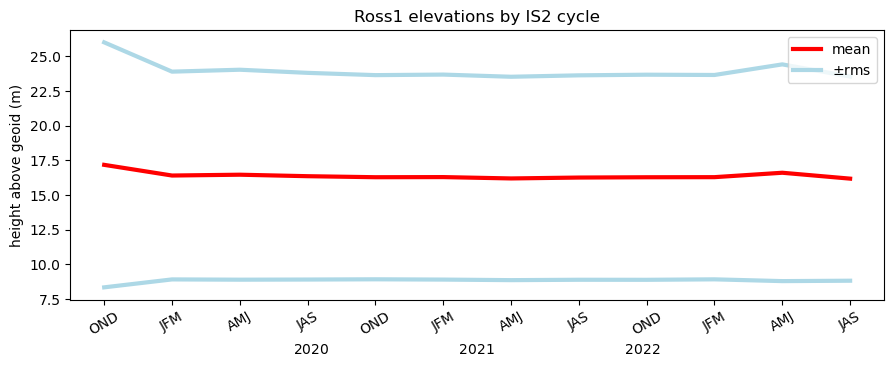

In [27]:
fudge = 10
#fudge = -7
fig, ax = plt.subplots(figsize=[10.5, 3.5])
#ax.scatter(np.array(melangeGDF.index[::10]), np.array(melangeGDF.h_mean[::10])+fudge, marker='o', s=25, alpha=0.25, color='black')
#ax.scatter(np.array(melangeGDF.index[::70]), np.array(melangeGDF.h_mean[::70])+fudge, marker='o', s=25, alpha=0.25, color='black')

cycles = list(melangeGDF.index.unique())
cycleMonths = [cycleMonthDict[f'{c:02}'][0] for c in cycles]

means = np.array([np.mean(melangeGDF[melangeGDF.index==i].h_mean) for i in melangeGDF.index.unique()])
stds = np.array([np.std(melangeGDF[melangeGDF.index==i].h_mean) for i in melangeGDF.index.unique()])
#rms = np.sqrt(np.array([np.mean(melangeGDF[melangeGDF.index==i].h_mean**2) for i in melangeGDF.index.unique()]))/np.sqrt(N)
#N = np.array([len(melangeGDF[melangeGDF.index==i].rgt.unique()) for i in melangeGDF.index.unique()])
#N = np.mean(N)
rms = np.sqrt(np.array([np.mean(melangeGDF[melangeGDF.index==i].h_mean**2) for i in melangeGDF.index.unique()]))

lw=3
#add 14 for ross
ax.plot(cycles, means+fudge, color='red', label='mean', linewidth=lw)
ax.plot(cycles, means+(rms)+fudge, color='lightblue', label='$\pm $rms', linewidth=lw)
ax.plot(cycles, means-(rms)+fudge, color='lightblue', linewidth=lw)
ax.set_xlim([4.5, 16.5])
#ax.set_ylim([-3, 19])
#ax.set_ylim([0, 60])
ax.set_xticks(cycles)
ax.set_xticklabels(cycleMonths, rotation=30)
ax.legend(loc='upper right')
ax.set_xlabel('2020 $\quad\quad\quad\quad\quad\quad\quad\quad\quad$ 2021 $\quad\quad\quad\quad\quad\quad\quad\quad\quad$ 2022')
ax.set_ylabel('height above geoid (m)')
#ax.set_title(f'Filchner F1 elevations by IS2 cycle')
#ax.set_title(f'Ross 1 elevations by IS2 cycle')
ax.set_title(f'{site.capitalize()} elevations by IS2 cycle')
#plt.savefig(f'{figRoot}{site}_byCycle_res{res}.png', 
#                        dpi=150, bbox_inches='tight')

Text(0.5, 1.0, 'Ross1 elevations by IS2 cycle')

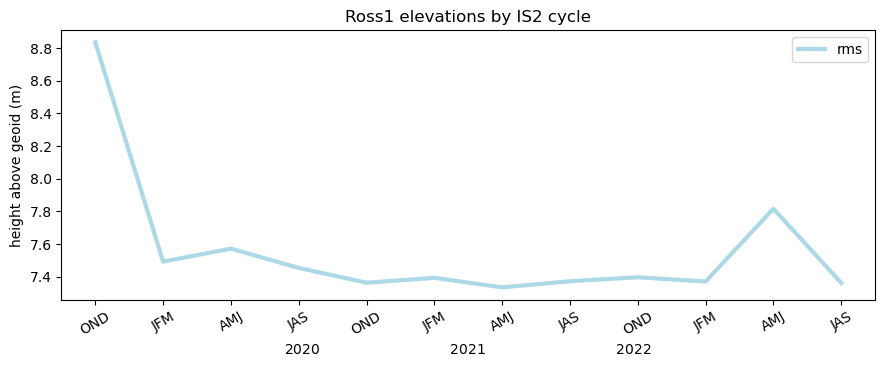

In [39]:
fudge = 10
#fudge = -7
fig, ax = plt.subplots(figsize=[10.5, 3.5])
#ax.scatter(np.array(melangeGDF.index[::10]), np.array(melangeGDF.h_mean[::10])+fudge, marker='o', s=25, alpha=0.25, color='black')
#ax.scatter(np.array(melangeGDF.index[::70]), np.array(melangeGDF.h_mean[::70])+fudge, marker='o', s=25, alpha=0.25, color='black')

cycles = list(melangeGDF.index.unique())
cycleMonths = [cycleMonthDict[f'{c:02}'][0] for c in cycles]

means = np.array([np.mean(melangeGDF[melangeGDF.index==i].h_mean) for i in melangeGDF.index.unique()])
stds = np.array([np.std(melangeGDF[melangeGDF.index==i].h_mean) for i in melangeGDF.index.unique()])
#rms = np.sqrt(np.array([np.mean(melangeGDF[melangeGDF.index==i].h_mean**2) for i in melangeGDF.index.unique()]))/np.sqrt(N)
N = np.array([len(melangeGDF[melangeGDF.index==i].rgt.unique()) for i in melangeGDF.index.unique()])
#N = np.mean(N)
rms = np.sqrt(np.array([np.mean(melangeGDF[melangeGDF.index==i].h_mean**2) for i in melangeGDF.index.unique()]))

lw=3
#add 14 for ross
#ax.plot(cycles, means+fudge, color='red', label='mean', linewidth=lw)
ax.plot(cycles, rms, color='lightblue', label='rms', linewidth=lw)
ax.set_xlim([4.5, 16.5])
#ax.set_ylim([-3, 19])
#ax.set_ylim([0, 60])
ax.set_xticks(cycles)
ax.set_xticklabels(cycleMonths, rotation=30)
ax.legend(loc='upper right')
ax.set_xlabel('2020 $\quad\quad\quad\quad\quad\quad\quad\quad\quad$ 2021 $\quad\quad\quad\quad\quad\quad\quad\quad\quad$ 2022')
ax.set_ylabel('height above geoid (m)')
#ax.set_title(f'Filchner F1 elevations by IS2 cycle')
#ax.set_title(f'Ross 1 elevations by IS2 cycle')
ax.set_title(f'{site.capitalize()} elevations by IS2 cycle')
#plt.savefig(f'{figRoot}{site}_byCycle_res{res}.png', 
#                        dpi=150, bbox_inches='tight')

Text(0.5, 1.0, 'Ross1 elevations by IS2 cycle')

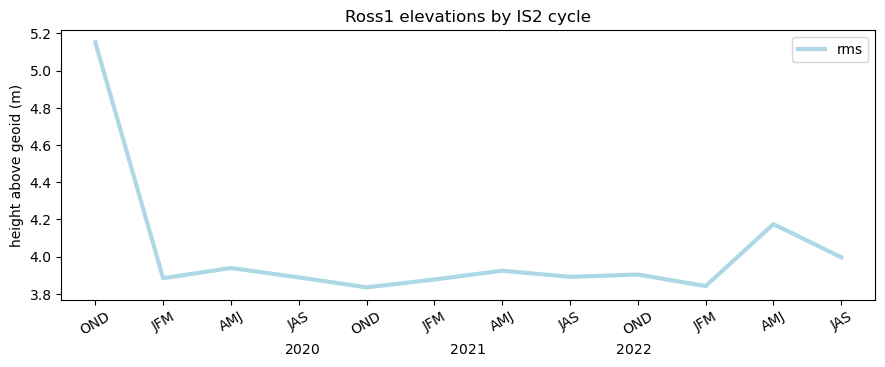

Text(0.5, 1.0, 'Filchnerf1 elevations by IS2 cycle')

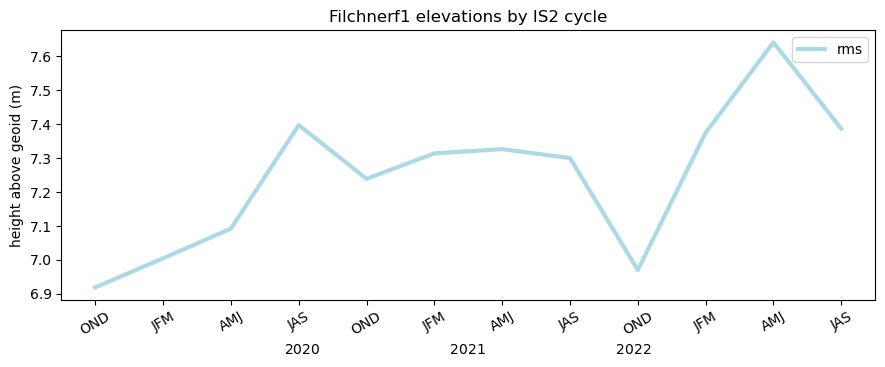

In [16]:
fudge = 10
#fudge = -7
fig, ax = plt.subplots(figsize=[10.5, 3.5])
#ax.scatter(np.array(melangeGDF.index[::10]), np.array(melangeGDF.h_mean[::10])+fudge, marker='o', s=25, alpha=0.25, color='black')
#ax.scatter(np.array(melangeGDF.index[::70]), np.array(melangeGDF.h_mean[::70])+fudge, marker='o', s=25, alpha=0.25, color='black')

cycles = list(melangeGDF.index.unique())
cycleMonths = [cycleMonthDict[f'{c:02}'][0] for c in cycles]

means = np.array([np.mean(melangeGDF[melangeGDF.index==i].h_mean) for i in melangeGDF.index.unique()])
stds = np.array([np.std(melangeGDF[melangeGDF.index==i].h_mean) for i in melangeGDF.index.unique()])
#rms = np.sqrt(np.array([np.mean(melangeGDF[melangeGDF.index==i].h_mean**2) for i in melangeGDF.index.unique()]))/np.sqrt(N)
#N = np.array([len(melangeGDF[melangeGDF.index==i].rgt.unique()) for i in melangeGDF.index.unique()])
#N = np.mean(N)
rms = np.sqrt(np.array([np.mean(melangeGDF[melangeGDF.index==i].h_mean**2) for i in melangeGDF.index.unique()]))

lw=3
#add 14 for ross
#ax.plot(cycles, means+fudge, color='red', label='mean', linewidth=lw)
ax.plot(cycles, stds, color='lightblue', label='rms', linewidth=lw)
ax.set_xlim([4.5, 16.5])
#ax.set_ylim([-3, 19])
#ax.set_ylim([0, 60])
ax.set_xticks(cycles)
ax.set_xticklabels(cycleMonths, rotation=30)
ax.legend(loc='upper right')
ax.set_xlabel('2020 $\quad\quad\quad\quad\quad\quad\quad\quad\quad$ 2021 $\quad\quad\quad\quad\quad\quad\quad\quad\quad$ 2022')
ax.set_ylabel('height above geoid (m)')
#ax.set_title(f'Filchner F1 elevations by IS2 cycle')
#ax.set_title(f'Ross 1 elevations by IS2 cycle')
ax.set_title(f'{site.capitalize()} elevations by IS2 cycle')
#plt.savefig(f'{figRoot}{site}_byCycle_res{res}.png', 
#                        dpi=150, bbox_inches='tight')

In [8]:
#filch = melangeGDF
#fudge = 10
fudge = -7
ross = melangeGDF

In [9]:
cyc = 12
rfudge = 10
ffudge = -7
bins = 15
filchcyc = filch[filch.index==cyc]
rosscyc = ross[ross.index==cyc]
plt.figure(figsize=[10.5, 3.5])
#names are wrong but fudge factors are right
plt.hist(rosscyc.h_mean+rfudge, color='#ffb58a', bins=bins, label='Filchner F1', edgecolor='black', density=True);
plt.hist(filchcyc.h_mean+ffudge, color='#8a8cff', alpha=0.75, bins=bins*2, label='Ross 1', edgecolor='black', density=True);
plt.legend()
plt.xlim([0, 50])
plt.xlabel('height above geoid (m)')
plt.ylabel('density')
plt.title(f'ICESat-2 Cycle {cyc} Mèlange Distributions')
plt.savefig(f'../figs/mel_dist_cyc{cyc}',dpi=150, bbox_inches='tight')

NameError: name 'filch' is not defined